Data from many different sources

# Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [3]:
from singlezone import run_singlezone, exp_sfh

In [4]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [5]:
def plot_abund_errs(df, x="O_H", y="C_O", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [6]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [7]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [8]:
def plot_sample_err(df, df_err, color=COLORS[0], marker="*", label="", **kwargs):
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, label=label, **kwargs)
    

    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [9]:
surp.set_yields(verbose=False)
c_o_correction = np.log10(12.01/15.99) - np.log10(vice.solar_z("c") / vice.solar_z("o"))
eps_o_correction =  - 12 + np.log10(15.99) - np.log10(vice.solar_z("o"))

# Stars
- Amarsi et al. 2019
- Bedell et al. 2018
- Zhao et al. 2016

## Amarsi et al. (2019)
3D NLTE corrected sample

Builds on: 
- Nissen et al. (2014)


In [10]:
amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)

amarsi19["FE_H"] = amarsi19["[Fe/H]3L"]
amarsi19["FE_H_err"] = amarsi19["e_[Fe/H]3L"]

amarsi19["O_H"] = amarsi19["[O/H]3N"]
amarsi19["O_H_err"] = amarsi19["e_[O/H]3N"]

amarsi19["C_H"] = amarsi19["[C/H]3N"]
amarsi19["C_H_err"] = amarsi19["e_[C/H]3N"]

amarsi19["C_O"] = amarsi19["C_H"] - amarsi19["O_H"] 
amarsi19["C_O_err"] = amarsi19["O_H_err"] + amarsi19["C_H_err"] 

amarsi19["O_FE"] = amarsi19["O_H"] - amarsi19["[Fe/H]3L"]
amarsi19["O_FE_err"] = amarsi19["e_[Fe/H]3L"] + amarsi19["O_H_err"]

amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/slurmtmp.29385702/ipykernel_237958/3749996996.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


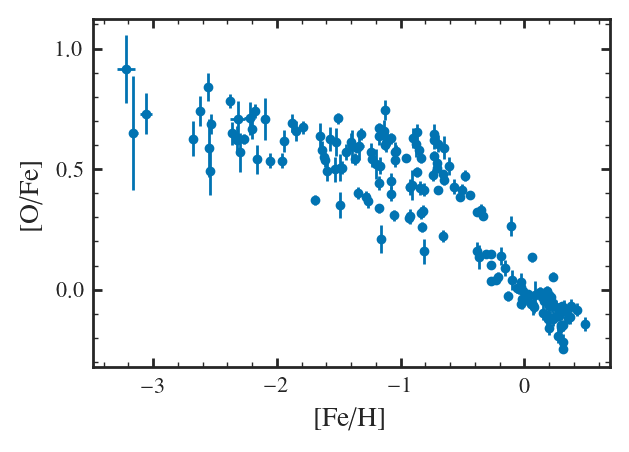

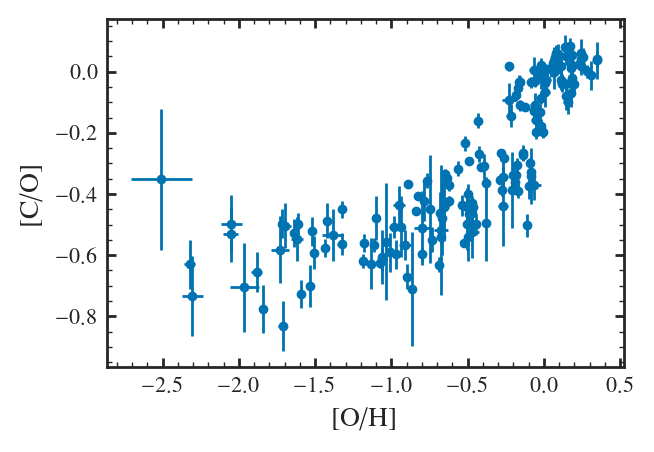

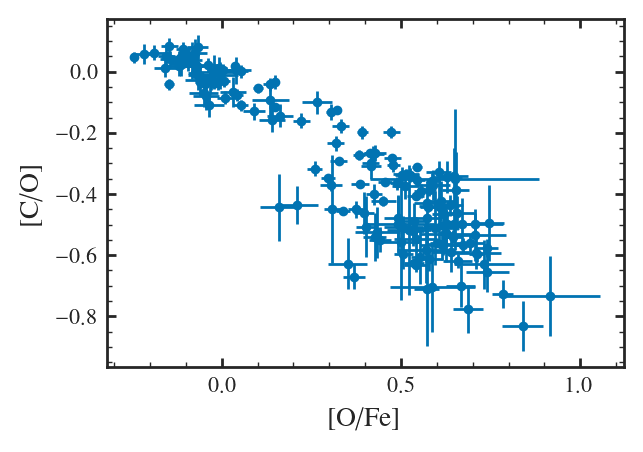

In [11]:
plot_sample(amarsi19)

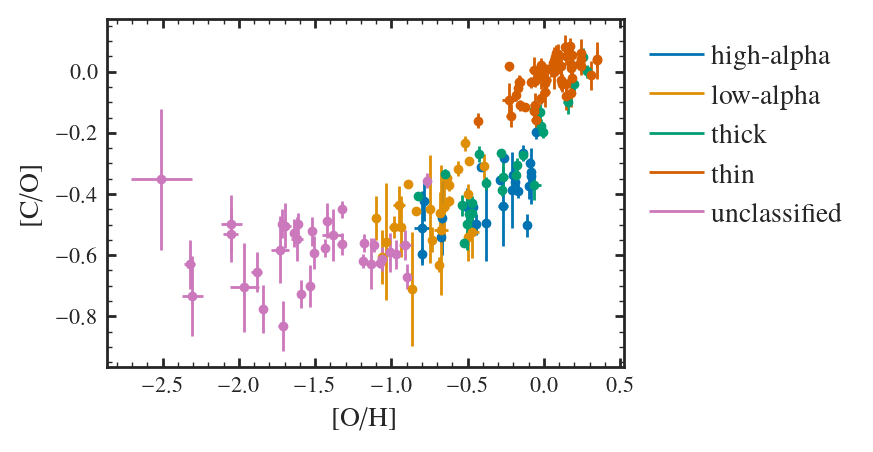

In [12]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plot_abund_errs(amarsi19[filt], label=pop)

arya.Legend(-1)


Text(0, 0.5, 'C_O')

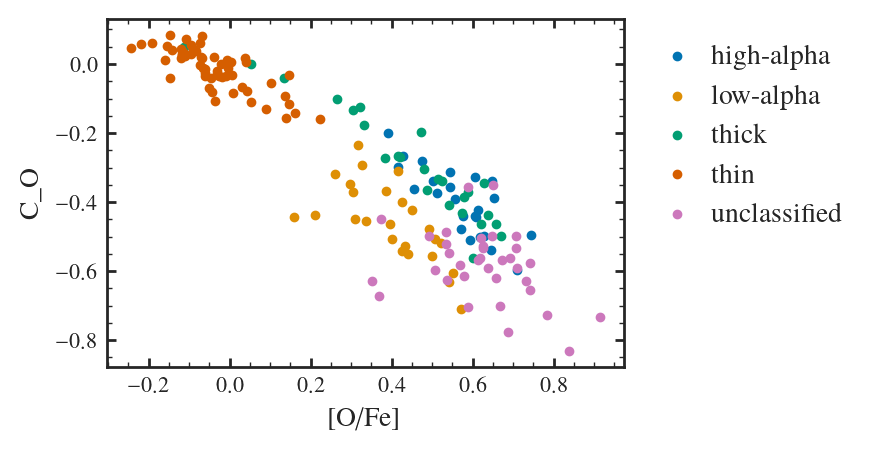

In [13]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plt.scatter(amarsi19[filt].O_FE, amarsi19[filt]["C_O"], label=pop)

arya.Legend(-1)
plt.xlabel("[O/Fe]")
plt.ylabel("C_O")

### NLTE vs LTE

while e.g. Fe is stable, C requires up to -0.2 dex corrections at low metallicities.

Text(0, 0.5, '3D LTE - 1D LTE')

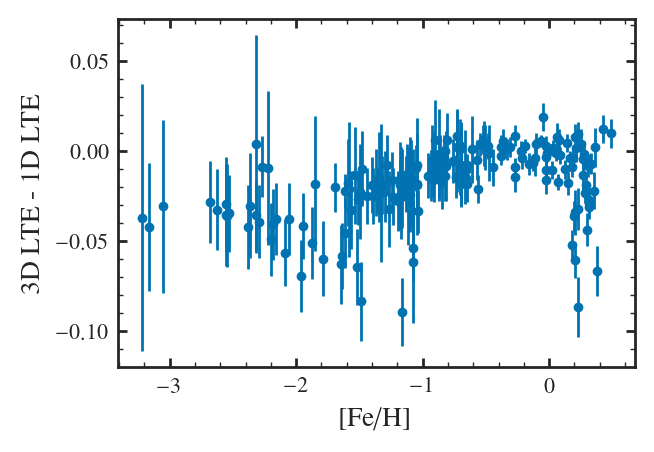

In [14]:
plt.errorbar(amarsi19.FE_H, amarsi19["[Fe/H]1L"] - amarsi19["[Fe/H]3L"], yerr=amarsi19["e_[Fe/H]3L"], fmt="o", capsize=0)
plt.xlabel("[Fe/H]")
plt.ylabel("3D LTE - 1D LTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

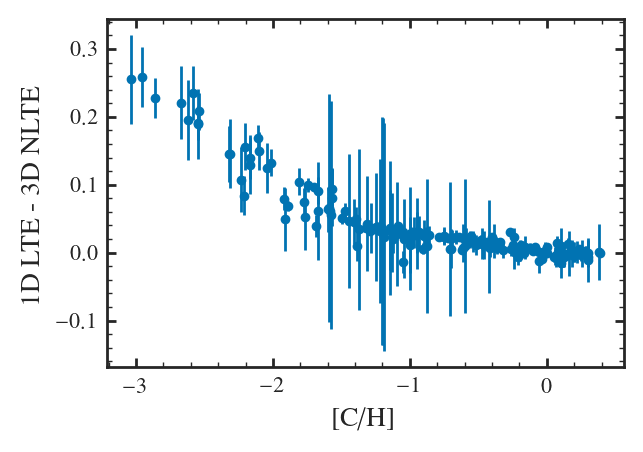

In [15]:
plt.errorbar(amarsi19.C_H, amarsi19["[C/H]1L"] - amarsi19["[C/H]3N"], yerr=amarsi19["e_[C/H]3N"], fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

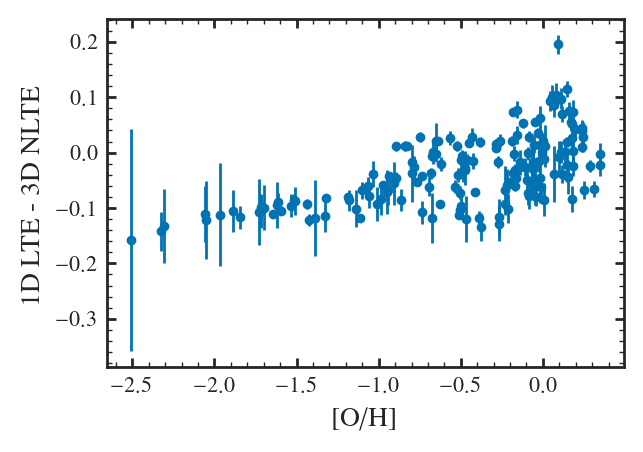

In [16]:
plt.errorbar(amarsi19.O_H, amarsi19["[O/H]1L"] - amarsi19["[O/H]3N"], yerr=amarsi19["e_[O/H]3N"], fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

## bedell 18
solar twins sample. https://ui.adsabs.harvard.edu/abs/2018ApJ...865...68B/abstract.
Doesn't help with global trends since all stars almost same


In [19]:
b18 = pd.read_csv(DATA_DIR + "bedell18.dat", delimiter=" +", comment="#")

/tmp/slurmtmp.29385702/ipykernel_237958/51954004.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  b18 = pd.read_csv(DATA_DIR + "bedell18.dat", delimiter=" +", comment="#")


Text(0, 0.5, '[C/O]')

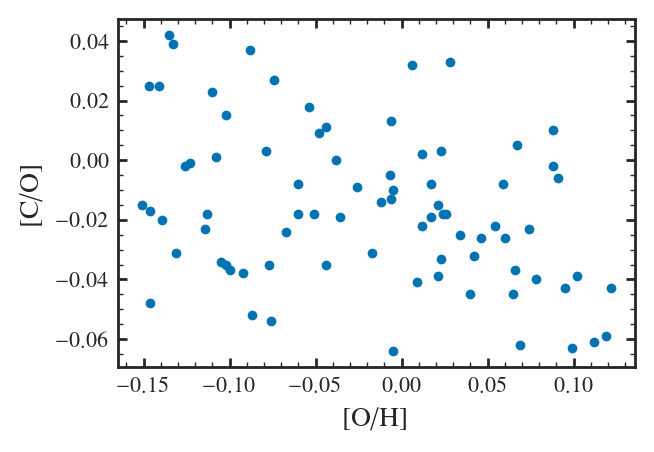

In [20]:
plt.scatter(b18["[OI/H]"], b18["[CI/H]"] - b18["[OI/H]"])
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

broadly consistant with APOGEE, not as interesting. 

## Zhao et al. 2016
https://ui.adsabs.harvard.edu/abs/2016ApJ...833..225Z/abstract

In [21]:
z16_long = pd.read_csv(DATA_DIR + "zhao+2016.tsv", delimiter="\t[ ]*", comment="#")

/tmp/slurmtmp.29385702/ipykernel_237958/2455137159.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  z16_long = pd.read_csv(DATA_DIR + "zhao+2016.tsv", delimiter="\t[ ]*", comment="#")


In [22]:
z16_long

,Name,Teff,logg,[Fe/H],xi,Pop,Z,Species,N,[X/H]LTE,e_[X/H]LTE,[X/Fe]LTE,[X/H]NLTE,e_[X/H]NLTE,[X/Fe]NLTE
0,HD 19373,6045,4.24,0.10,1.2,Thin disk,3.0,Li I,1,2.50,NaN,NaN,2.47,NaN,NaN
1,HD 19373,6045,4.24,0.10,1.2,Thin disk,6.0,C I,5,0.00,0.04,-0.10,-0.05,0.05,-0.15
2,HD 19373,6045,4.24,0.10,1.2,Thin disk,NaN,CH,13,0.10,0.06,0.00,NaN,NaN,NaN
3,HD 19373,6045,4.24,0.10,1.2,Thin disk,8.0,O I,4,0.01,0.01,-0.09,-0.06,0.04,-0.16
4,HD 19373,6045,4.24,0.10,1.2,Thin disk,11.0,Na I,4,0.27,0.06,0.17,0.21,0.04,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,G090-003,6007,3.90,-2.04,1.3,Halo,29.0,Cu I,0,NaN,NaN,NaN,NaN,NaN,NaN
1016,G090-003,6007,3.90,-2.04,1.3,Halo,38.0,Sr II,2,-1.98,0.01,0.06,-2.13,0.00,-0.09
1017,G090-003,6007,3.90,-2.04,1.3,Halo,40.0,Zr II,2,-1.67,0.05,0.37,-1.65,0.04,0.39
1018,G090-003,6007,3.90,-2.04,1.3,Halo,56.0,Ba II,4,-2.12,0.07,-0.08,-2.00,0.05,0.04


In [23]:
z16 = z16_long.pivot_table(index='Name', columns='Species', 
    values=['[X/H]LTE', 'e_[X/H]LTE', '[X/Fe]LTE', '[X/H]NLTE', 'e_[X/H]NLTE','[X/Fe]NLTE'], aggfunc='first')


In [24]:
z16.columns = [a.replace("X", b.strip()).replace("NLTE", "") for a, b in z16.columns.values]

In [25]:
z16 = pd.merge(z16_long[["Name", "Teff", "logg", "[Fe/H]", "xi"]].drop_duplicates(), z16, on='Name')

In [26]:
z16.columns.values

array(['Name', 'Teff', 'logg', '[Fe/H]', 'xi', '[Al I/Fe]LTE',
       '[Ba II/Fe]LTE', '[C I/Fe]LTE', '[CH/Fe]LTE', '[Ca I/Fe]LTE',
       '[Cu I/Fe]LTE', '[Eu II/Fe]LTE', '[Fe I/Fe]LTE', '[Fe II/Fe]LTE',
       '[K I/Fe]LTE', '[Mg I/Fe]LTE', '[Na I/Fe]LTE', '[O I/Fe]LTE',
       '[Sc II/Fe]LTE', '[Si I/Fe]LTE', '[Si II/Fe]LTE', '[Sr II/Fe]LTE',
       '[Ti II/Fe]LTE', '[Zr II/Fe]LTE', '[Al I/Fe]', '[Ba II/Fe]',
       '[C I/Fe]', '[Ca I/Fe]', '[Cu I/Fe]', '[Eu II/Fe]', '[Fe I/Fe]',
       '[Fe II/Fe]', '[K I/Fe]', '[Mg I/Fe]', '[Na I/Fe]', '[O I/Fe]',
       '[Sc II/Fe]', '[Si I/Fe]', '[Si II/Fe]', '[Sr II/Fe]',
       '[Ti II/Fe]', '[Zr II/Fe]', '[Al I/H]LTE', '[Ba II/H]LTE',
       '[C I/H]LTE', '[CH/H]LTE', '[Ca I/H]LTE', '[Cu I/H]LTE',
       '[Eu II/H]LTE', '[Fe I/H]LTE', '[Fe II/H]LTE', '[K I/H]LTE',
       '[Li I/H]LTE', '[Mg I/H]LTE', '[Na I/H]LTE', '[O I/H]LTE',
       '[Sc II/H]LTE', '[Si I/H]LTE', '[Si II/H]LTE', '[Sr II/H]LTE',
       '[Ti II/H]LTE', '[Zr II/H]LTE', '[Al I

Text(0, 0.5, 'logg')

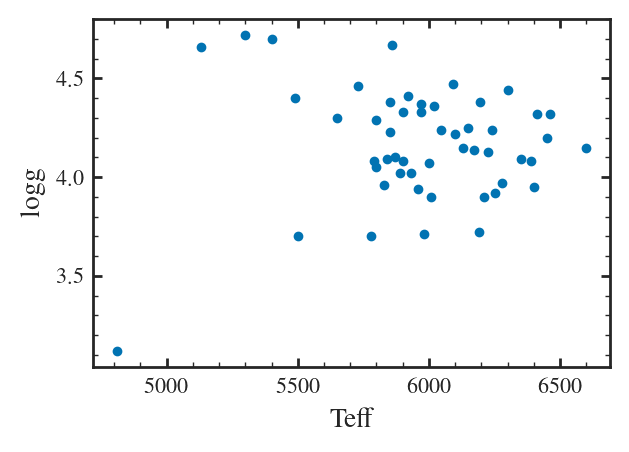

In [27]:
plt.scatter(z16.Teff, z16.logg)
plt.xlabel("Teff")
plt.ylabel("logg")

In [28]:
z16["C_H"] = z16["[C I/H]"] 
z16["C_H_err"] = z16["e_[C I/H]"] 


z16["C_O"] = z16["[C I/H]"] - z16["[O I/H]"]
z16["C_O_err"] = z16["e_[C I/H]"] - z16["e_[O I/H]"]

z16["O_H"] = z16["[O I/H]"]
z16["O_H_err"] = z16["e_[O I/H]"]

z16["FE_H"] = z16["[Fe I/H]"]
z16["FE_H_err"] = z16["e_[Fe I/H]"]

z16["O_FE"] = z16["[O I/Fe]"]
z16["O_FE_err"] = z16["e_[O I/H]"] + z16["e_[Fe I/H]"]

Text(0, 0.5, '1D LTE - 3D NLTE')

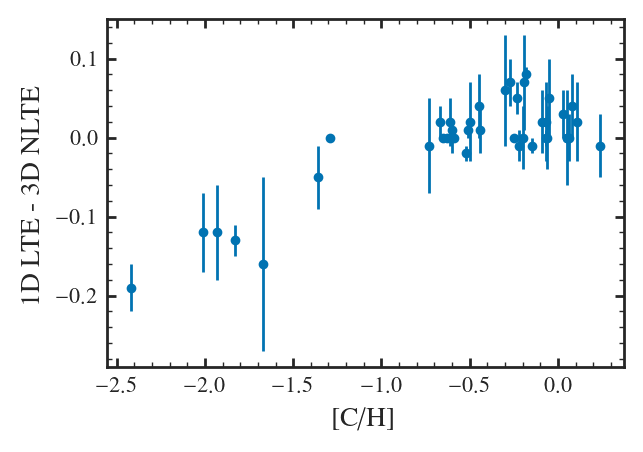

In [29]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

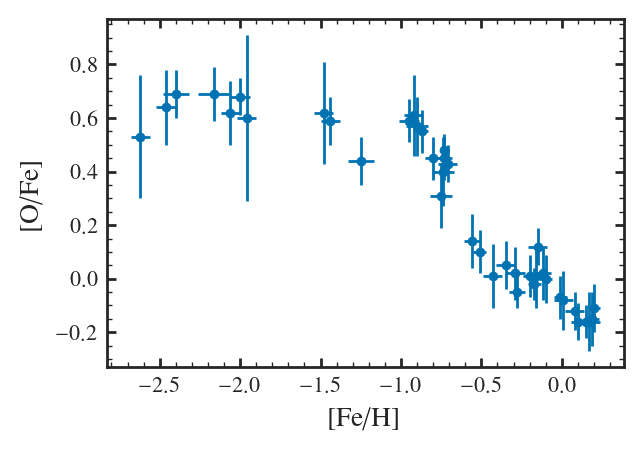

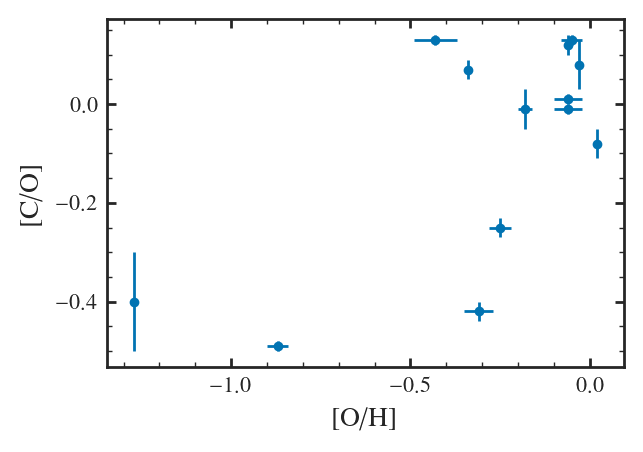

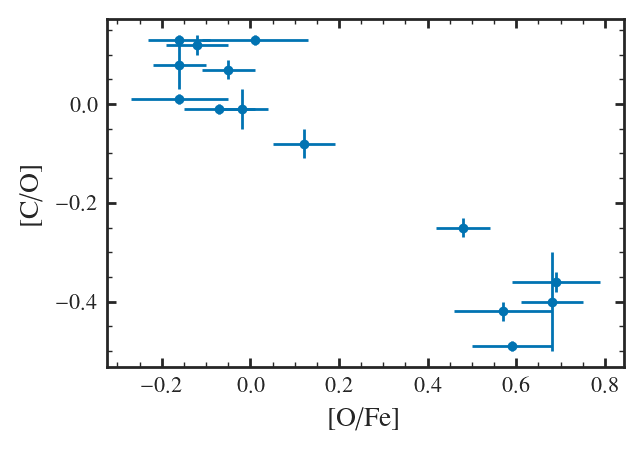

In [30]:
plot_sample(z16)

Text(0, 0.5, '1D LTE - 3D NLTE')

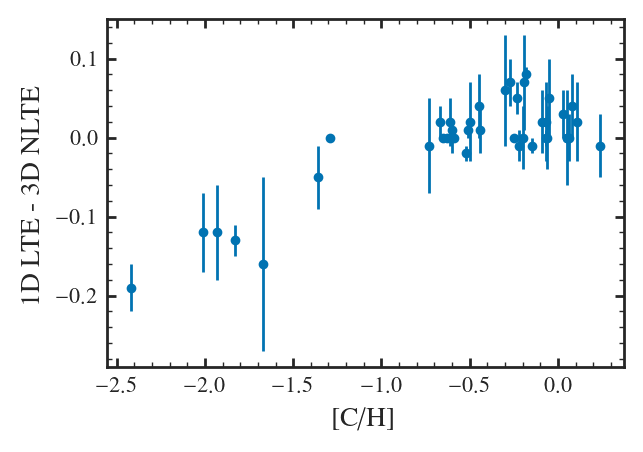

In [31]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

Text(0, 0.5, 'CH - C I')

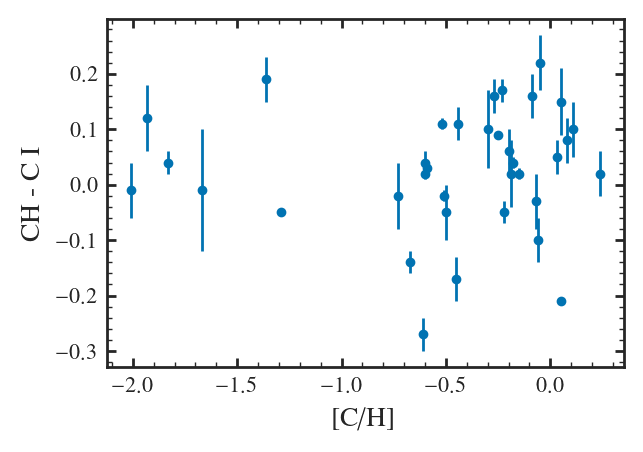

In [32]:
plt.errorbar(z16.C_H, z16["[CH/Fe]LTE"] - z16.C_H + z16.FE_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("CH - C I")

Text(0, 0.5, '1D LTE - 3D NLTE')

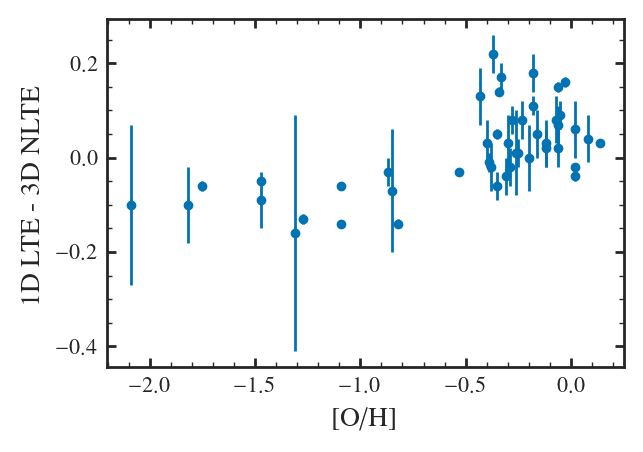

In [33]:
plt.errorbar(z16.O_H, z16["[O I/H]LTE"] - z16.O_H, yerr=z16.O_H_err, fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

## Bensby et al. (2019, 2021)
The galactic bulge sample

In [34]:
bensby21 = pd.read_csv(DATA_DIR + "bensby21.tsv", delimiter="\t *", comment="#",engine='python')
bensby19 = pd.read_csv(DATA_DIR + "bensby19.tsv", delimiter="\t *", comment="#",engine='python')

bensby = bensby21.set_index("Name").join(bensby19.set_index("Name"),rsuffix="_b19", how="left")

bensby["C_O"] = bensby["[C/H]"] - bensby["[O/H]"]
bensby["C_O_err"] = bensby["e_[C/O]"]

bensby["O_FE"] = bensby["[O/H]"] - bensby["[Fe/H]"]
bensby["O_FE_err"] = bensby["e_[O/H]"] + bensby["e_[Fe/H]"]

bensby["O_H"] = bensby["[O/H]"]
bensby["O_H_err"] = bensby["e_[O/H]"]

bensby["FE_H"] = bensby["[Fe/H]"]
bensby["FE_H_err"] = bensby["e_[Fe/H]"]


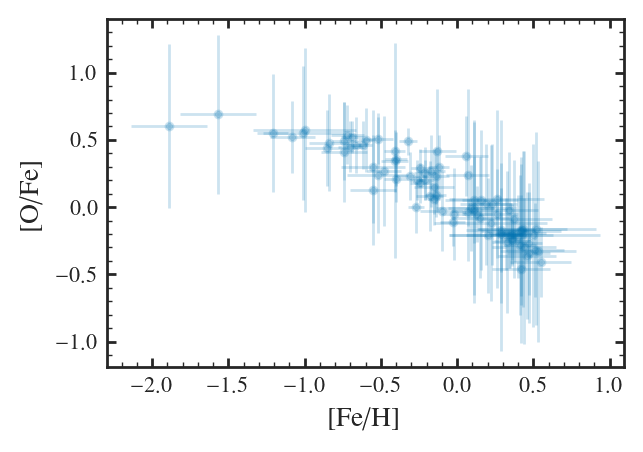

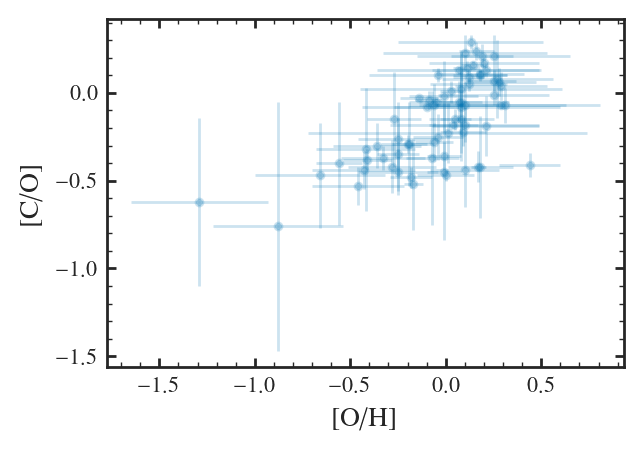

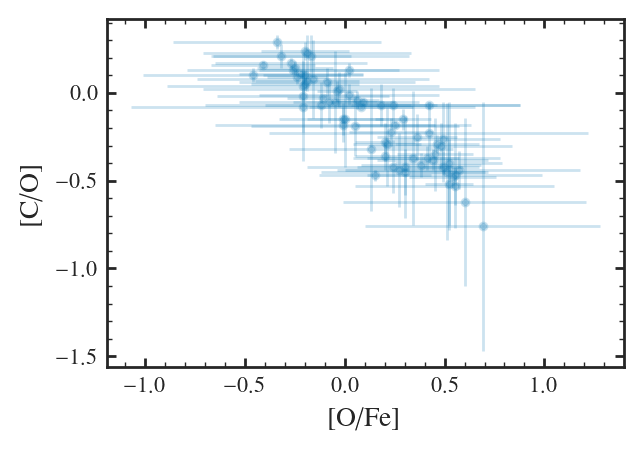

In [35]:
plot_sample(bensby, alpha=0.2)

## extra

In [36]:
F09 = pd.read_csv(DATA_DIR + "Fabbian09.csv", sep="\s+")

In [37]:
flf21 = pd.read_csv(DATA_DIR + "FLF21.csv", delimiter="\s+", comment="#")
flf21["[o/h]"] = flf21["[O/Fe]"] + flf21["[Fe/H]"]
flf21["[c/o]"] = flf21["[C/Fe]"] - flf21["[O/Fe]"]

# NOT COMPARABLE SAMPLE< HAS GIANTZ

In [38]:
dm21 = pd.read_csv(DATA_DIR + "dm21.csv", delimiter="\t *", comment="#", engine="python")
dm21["O_H"] = dm21["[O1/Fe]"] + dm21["[Fe/H]"]
dm21["O_H_err"] = dm21["e_[O1/Fe]"]


dm21["C_O"] = dm21["[C/O2]"]
dm21["C_O_err"] = dm21["e_[C/Fe]"] + dm21["e_[O1/Fe]"]

dm21["FE_H"] = dm21["[Fe/H]"]
dm21["FE_H_err"] = 0.0001



dm21["O_FE"] = dm21["[O2/Fe]"]
dm21["O_FE_err"] = dm21["e_[O2/Fe]"]

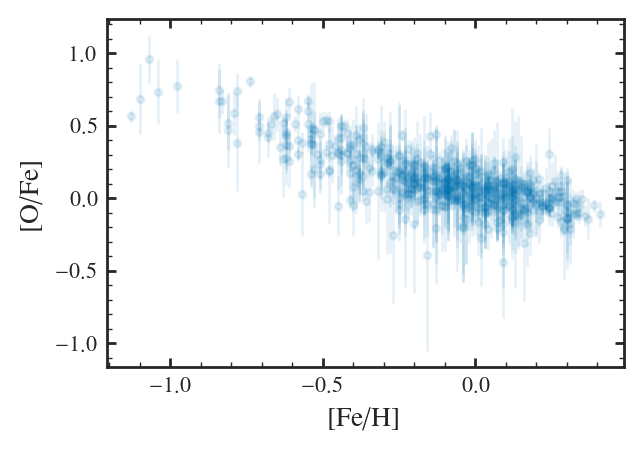

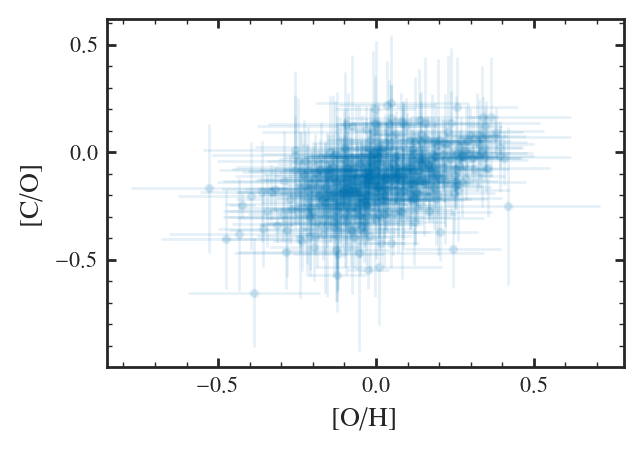

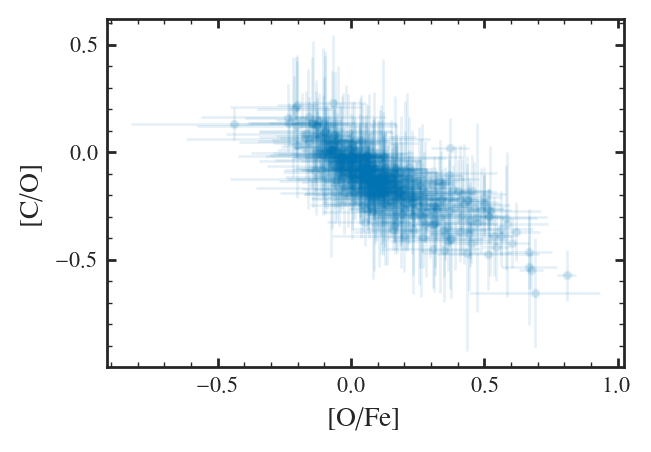

In [39]:
plot_sample(dm21, alpha=0.1)

## all stars

In [40]:
all_stars = amarsi19

In [41]:
all_star_err = pd.DataFrame()


# split into two regemes and plot error bars
mh_cut = -0.3

low_z = all_stars[all_stars["O_H"] < mh_cut]
high_z = all_stars[all_stars["O_H"] >= mh_cut]
all_star_err = pd.concat([calc_errs(low_z), calc_errs(high_z)], ignore_index=True)
all_star_err

,O_H_err,C_O_err,O_H,C_O
0,0.023074,0.060948,-1.0091,-0.5907
1,0.018365,0.031701,0.0018,-0.0034


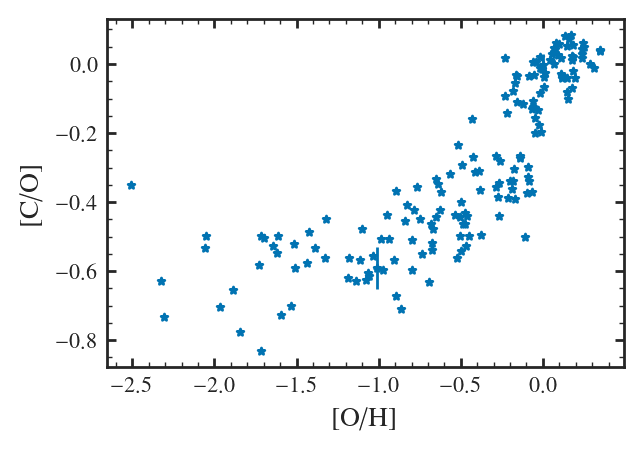

In [42]:
plot_sample_err(all_stars, all_star_err)

# RL

work from
- Esteban et al . (2002, 2009, 2014)
- García-Rojas et al. (2007)
- López-Sánchez et al. (2007)
- Mendez-Delgado et al. 2022
- Skillman et al. (2020)
- Toribio San Cipriano et al. 2016, 2017.
- Peimbert et al. 2005


Other
- Peimberg 2003 does 30 Dor in LMC (like TSC)
- García-Rojas 2003, 2004, 2006 (galactic regions)
- Tsamis et al. 2003. (galactic and LMC, covered by more modern studies)



Included

## Skillman et al. 2020
M101 data from CHAOS

In [44]:
def read_skillman20():
    df = pd.read_csv(DATA_DIR + "chaos_m101.dat", sep="\s+")
    df1 = pd.DataFrame()
    df1["O_H"] = gcem.eps_to_brak(df["O_H"], "o")
    df1["C_O"] = gcem.log_to_brak(df["C_O"], "c", "o")
    df1["[c/n]"] = gcem.log_to_brak(df["C_N"], "c", "n")
    df1["[n/o]"] = df1["C_O"] - df1["[c/n]"]

    df1["O_H_err"] = df["O_H_err"]
    df1["C_O_err"] = df["C_O_err"] 
    df1["[c/n]_err"] = df["C_N_err"] * 12/14
    df1["[n/o]_err"] = df["C_O_err"] + df["C_N_err"]

    df1.name="M101"
    return df1

skillman20 = read_skillman20()

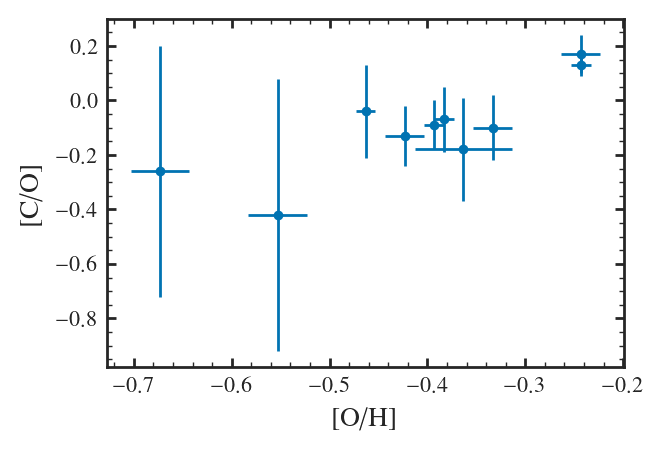

In [45]:
plot_abund_errs(skillman20)

##  Toribio San Cipriano et al. (2016)
NGC 300 and M33 abundances using RL on UVES

In [46]:
tsc16 = pd.read_csv(f"{DATA_DIR}/TSC16.tsv", sep=r"\s+", comment="#")

In [47]:
tsc16["O_H"] = gcem.eps_to_brak(tsc16.eps_o, "o")
tsc16["O_H_err"] = tsc16.eps_o_err
tsc16["C_O"] = gcem.log_to_brak(tsc16.log_c_o, "c", "o")
tsc16["C_O_err"] = tsc16.log_c_o_err

In [48]:
tsc16

,galaxy,object,eps_o,eps_o_err,log_c_o,log_c_o_err,O_H,O_H_err,C_O,C_O_err
0,NGC300,R20,8.69,0.11,-0.22,0.22,-0.123177,0.11,-0.00963,0.22
1,NGC300,R23,8.70,0.13,-0.43,0.23,-0.113177,0.13,-0.21963,0.23
2,NGC300,R14,8.62,0.11,-0.36,0.21,-0.193177,0.11,-0.14963,0.21
3,NGC300,R2,8.57,0.12,-0.52,0.22,-0.243177,0.12,-0.30963,0.22
4,M33,NGC588,8.49,0.09,-0.47,0.19,-0.323177,0.09,-0.25963,0.19
5,M33,IC132,8.47,0.12,-0.33,0.15,-0.343177,0.12,-0.11963,0.15


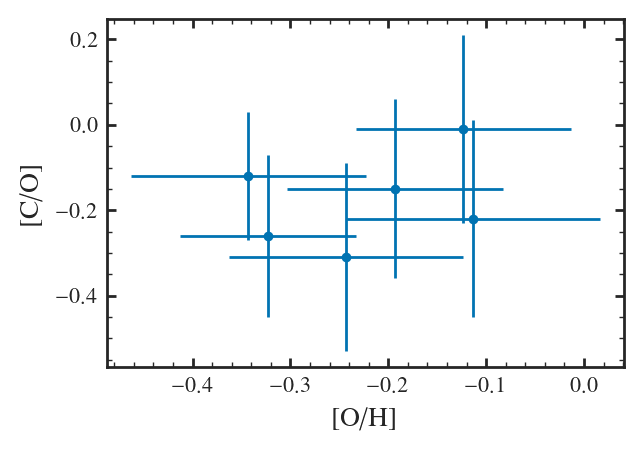

In [49]:
plot_abund_errs(tsc16)

##  Toribio San Cipriano et al. (2017)
LMC and SMC abundances using RL, 5 and 4 HII regions respectively.
Compares to CEL lines
- C II 4267.15
- ~ 7 \[O II\] lines

In [50]:
tsc17 = pd.read_csv(f"{DATA_DIR}/TSC17.tsv", sep=r"\s+", comment="#")

In [51]:
tsc17["O_H"] = gcem.eps_to_brak(tsc17.eps_o, "o")
tsc17["O_H_err"] = tsc17.eps_o_err
tsc17["C_O"] = gcem.log_to_brak(tsc17.log_c_o, "c", "o")
tsc17["C_O_err"] = tsc17.log_c_o_err

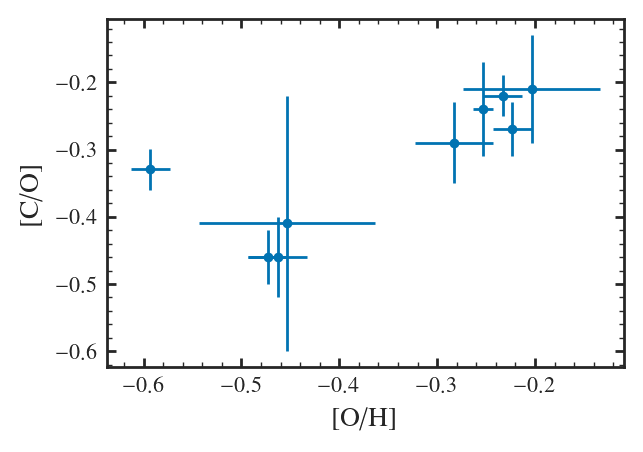

In [52]:
plot_abund_errs(tsc17)

## Mendez-Delgado et al. 2022
MW HII regions

In [53]:
def read_md22():
    df = pd.read_csv(DATA_DIR + "md22.csv")
    df1 = pd.DataFrame()
    df1["O_H"] = gcem.eps_to_brak(df["O_H"], "o")
    df1["[c/h]"] = gcem.eps_to_brak(df["C_H"], "c")
    df1["[n/h]"] = gcem.eps_to_brak(df["N_H"], "n")

    df1["[c/n]"] = df1["[c/h]"] - df1["[n/h]"]
    df1["C_O"] = df1["[c/h]"] - df1["O_H"]
    df1["[n/o]"] = df1["[n/h]"] - df1["O_H"]

    df1["O_H_err"] = df["O_H_err"]
    df1["C_O_err"] = df["C_H_err"] + df["O_H_err"]
    df1["[n/o]_err"] = df["N_H_err"] + df["O_H_err"]
    df1["[c/n]_err"] = df["C_H_err"] + df["N_H_err"]

    df1.name = "Milkyway"
    return df1
md22 = read_md22()
md22a = pd.read_csv(DATA_DIR + "md22.csv")


Text(0, 0.5, 'eps C')

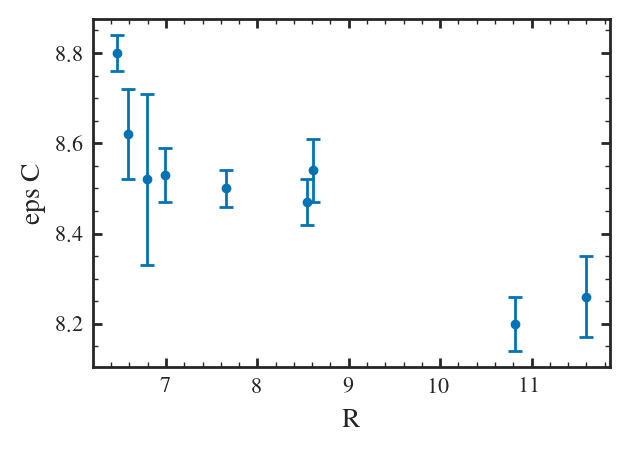

In [54]:
plt.errorbar(md22a.R_g, md22a.C_H, yerr=md22a.C_H_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps C")

Text(0, 0.5, 'eps(O)')

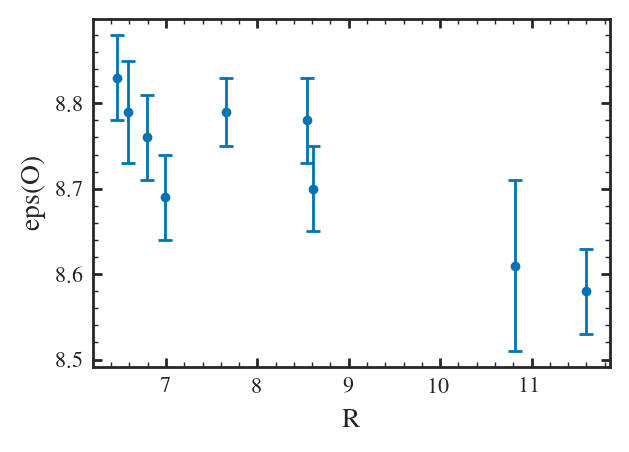

In [55]:
plt.errorbar(md22a.R_g, md22a.O_H, yerr=md22a.O_H_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps(O)")

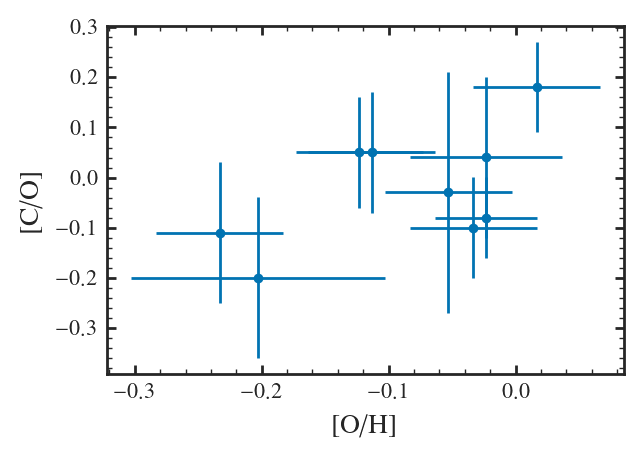

In [56]:
plot_abund_errs(md22)

## Misc

### Peimbert & Peimbert 2005
NGC 6822 (dwarf Irr) on VLT, RLs

- CII 4267
- CII 6151
- CII 6734

4 OII lines

### E02

### LS 07
NGC 5253



In [57]:
RL = pd.read_csv(DATA_DIR + "extragalactic_RL.csv", sep="\s+")
RL["C_O"] = gcem.log_to_brak(RL.eps_c - RL.eps_o, "c", "o")
RL["O_H"] = gcem.eps_to_brak(RL.eps_o, "o")
RL["C_O_err"] = np.sqrt(RL.c_err**2 + RL.o_err**2)
RL["O_H_err"] = RL.o_err 

In [58]:
RL.drop(np.where(np.isin(RL["object"], ["VS-24", "VS-38", "NGC-5447", "30-Dor",
                                       "M8", "M17"]))[0], inplace=True)


In [59]:
RL

,source,galaxy,class,object,eps_c,c_err,eps_n,n_err,eps_o,o_err,eps_fe,fe_err,C_O,O_H,C_O_err,O_H_err
0,E02,NGC-5471,?,?,7.79,NaN,6.51,0.15,8.23,0.05,6.36,0.09,-0.22963,-0.583177,NaN,0.05
1,E09,M31,S,K932,8.46,0.13,7.63,0.06,8.62,0.03,5.90,0.09,0.05037,-0.193177,0.133417,0.03
2,E09,M33,Sc,NGC-595,8.53,0.12,7.53,0.10,8.69,0.05,5.55,0.21,0.05037,-0.123177,0.130000,0.05
3,E09,M33,Sc,NGC-604,8.40,0.11,7.49,0.07,8.60,0.03,5.94,0.11,0.01037,-0.213177,0.114018,0.03
4,E09,NGC-2366,Ir,NGC-2363,7.75,0.09,6.70,0.10,8.04,0.05,5.71,0.23,-0.07963,-0.773177,0.102956,0.05
7,E09,NGC-2403,Sc,VS-44,8.32,0.18,7.52,0.08,8.61,0.04,6.13,0.12,-0.07963,-0.203177,0.184391,0.04
8,E09,M101,Sc,H1013,8.67,0.12,7.82,0.19,8.73,0.09,5.98,0.26,0.15037,-0.083177,0.150000,0.09
9,E09,M101,Sc,NGC-5461,8.30,0.20,7.54,0.11,8.49,0.06,6.15,0.21,0.02037,-0.323177,0.208806,0.06
11,E09,NGC-1741,Im-D,Zone-C,NaN,NaN,7.36,0.18,8.41,0.06,5.95,0.25,NaN,-0.403177,NaN,0.06
12,E09,NGC-4395,SA(s)m,Reg-70,NaN,NaN,6.56,0.28,8.09,0.15,5.97,0.42,NaN,-0.723177,NaN,0.15


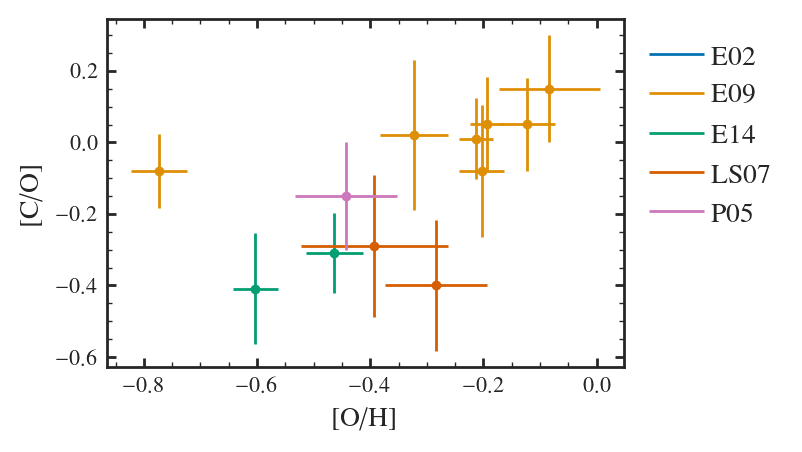

In [60]:
for label in RL.source.unique():
    df = RL.loc[RL.source == label]

    plot_abund_errs(df, label=label)
    
arya.Legend(loc=-1)

## All

In [61]:
RLs = pd.concat([RL, md22, skillman20, tsc16, tsc17])
RL_err = calc_errs(RLs)

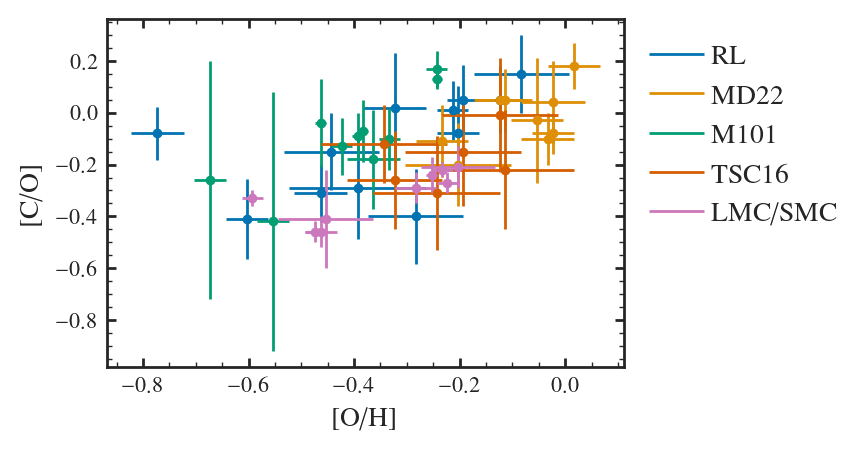

In [62]:
for i in range(5):
    sample = [RL, md22, skillman20, tsc16, tsc17][i]
    label = ["RL", "MD22", "M101", "TSC16", "LMC/SMC"][i]
    plot_abund_errs(sample, label=label)
    
arya.Legend(-1)

## All

In [63]:
RLs = pd.concat([RLs, skillman20, md22, tsc16, tsc17], ignore_index=True)
RL_err = calc_errs(RLs)

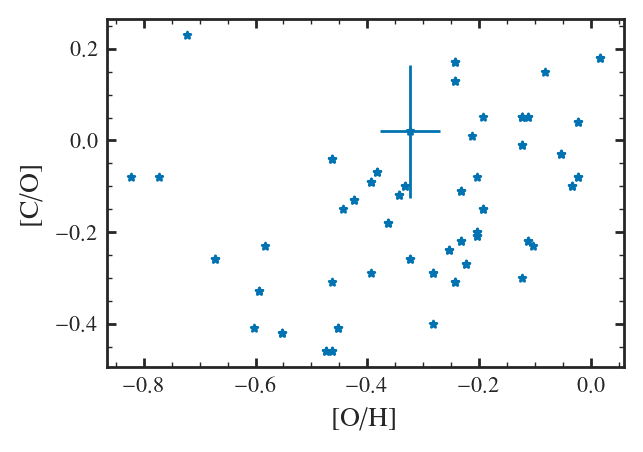

In [64]:
plot_sample_err(RLs, RL_err)

# Dwarfs (CELs)
- berg 2016, 2019
- Peña-Guerrero et al. 2017 (DUST CORRECTIONS?! also look at GCE discussion)

## Senchyna et al. 2017

## Peña-Guerrero et al. 2017
HST 
- 1909 C III]

10 [O III]  and [O II] lines

In [65]:
pg17 = pd.read_csv(DATA_DIR + "/pena-guerreno+17.csv", sep=r"\s+")


In [66]:
pg17["O_H"] = gcem.eps_to_brak(pg17.eps_o, "o")
pg17["O_H_err"] = pg17.eps_o_err

pg17["C_H"] = gcem.eps_to_brak(pg17.eps_c, "c")
pg17["C_H_err"] = pg17.eps_c_err

pg17["C_O"] = pg17.C_H - pg17.O_H
pg17["C_O_err"] = pg17.C_H_err + pg17.O_H_err

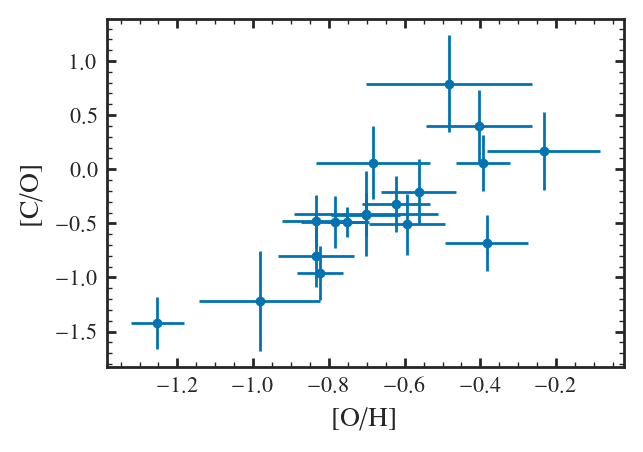

In [67]:
plot_abund_errs(pg17)

## Berg et al. 2019

CEL using UV spectroscopy from HST


In [68]:
berg19_oh = [7.738564437848462, 7.6632886767478245, 7.747268460952228, 7.750820263928443, 7.713715855761903, 7.589795836508764, 7.6974589868035785, 7.645978901768882, 7.6295676065942, 7.544970117524367, 7.612033211664193, 7.583534555372829, 7.72890577995267, 7.697318599334163, 7.712185632345273, 7.868184188359874, 7.91372588343829, 7.910117925474309, 8.026962416268903]
berg19_co = [-0.3746933819064967, -0.48816029143898, -0.5211171827565271, -0.5504310868245295, -0.5995992714025501, -0.6620036429872496, -0.7178384942319369, -0.7848573163327262, -0.8006435944140862, -0.8836429872495446, -0.9455737704918032, -1.038554948391014, -1.0339647844565878, -0.7561748633879781, -0.7804857316332725, -0.655397692774742, -0.5993321190042502, -0.7889981785063751, -0.8897632058287797]

In [69]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 0.00e+00 (Z - Z0)   1.00 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [70]:
berg19 = pd.read_csv(DATA_DIR + "berg19.csv")
berg19 = berg19.iloc[:-1]
berg19["C_O"] = gcem.log_to_brak(berg19.log_c_o, "c", "o")
berg19["O_H"] = gcem.eps_to_brak(berg19.eps_o, "o")
berg19["C_O_err"] = berg19.log_c_o_err
berg19["O_H_err"] = berg19.eps_o_err

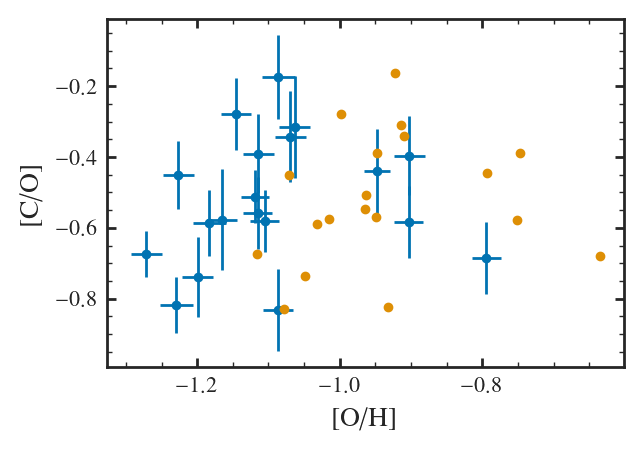

In [71]:
plt.scatter(berg19_oh + eps_o_correction, berg19_co + c_o_correction, color=COLORS[1], zorder=3)
plot_abund_errs(berg19)

## Berg 2016

Carbon lines
- C IV 1548.19 (3)
- C IV 1550.77 (3)
- C III] 1906.68 (all - 1)
- C III 1908.73 (all)
about 8 O lines, and 4 H lines. No Fe.

In [73]:
berg16 = pd.read_csv(DATA_DIR + "berg16.csv")
berg16["C_O"] = gcem.log_to_brak(berg16.log_c_o, "c", "o")
berg16["O_H"] = gcem.eps_to_brak(berg16.eps_o, "o")
berg16["C_O_err"] = berg16.log_c_o_err
berg16["O_H_err"] = berg16.eps_o_err

In [74]:
berg16_eps_o = [7.45492559464121, 7.45492559464121, 7.446516385223216, 7.738760980305644, 7.812141510569171, 7.844879868436886, 7.91093217279692]
berg16_co = [-0.44879174256223436, -0.5934790528233151, -0.6725804493017608, -0.8203400121432909, -0.6636915604128719, -0.6061323618700668, -0.6431086824529447]

In [75]:
berg16_eps_o = [7.3688668986515875, 7.451109177903437, 7.4524684645498045, 7.732209656372336, 7.901859504132231, 7.808971291866029, 7.841028708133972]
berg16_co = [-0.2890780583536705, -0.45288545792930646, -0.7084163112195758, -0.8311306476258066, -0.7682472897913665, -0.6335624126469162, -0.5935121552042524]

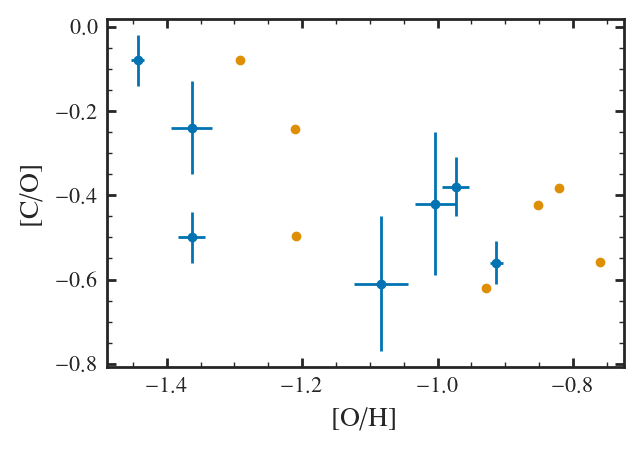

In [76]:
plot_abund_errs(berg16)
plt.scatter(berg16_eps_o + eps_o_correction, berg16_co + c_o_correction, color=COLORS[1], zorder=3)


## All

In [77]:
dwarfs = pd.concat([berg16, berg19], ignore_index=True)
dwarf_err = calc_errs(dwarfs)

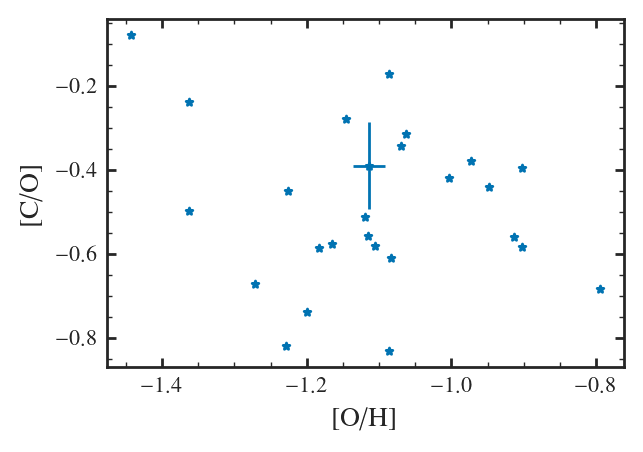

In [78]:
plot_sample_err(dwarfs, dwarf_err)

# TODO pay attention to RL, CEL corrections and dwarf galaxy catagorizations

# High Z galaxies
High z CEL mentioned in berg and jones

- Pettini et al. 2000
- Fosbury & Villar-Martín et al. 2003
- Fosbury et al. 2003
- Erb et al. 2010
- Christensen et al. 2012
- Bayliss et al. 2014
- James et al. 2014
- Stark et al. 2014
- Steidel et al. 2016
- Vanzella et al. 2016
- Amorín et al. 2017
- Berg et al. 2018
- Rigby et al. 2018
- Mainali et al. 2020
- Matthee et al. 2021
- Rigby et al. 2021
- Iani et al. 2023

JWST results
- AC 2022
- Jones + 2023


### S04590
from Arellano-Córdova et al. 2022 (https://ui.adsabs.harvard.edu/abs/2022ApJ...940L..23A).
lines: 
- C III] 1907
- C III] 1909

### Jones + 2023
similar to above, but for a different galaxy
- C IV 1548.19 
- C IV 1550.77
- C III] 1906.68 
- C III] 1908.73

and two O lines (CEL UV)

Result:
- log(C/O) = -1.01 pm 0.12 (stat) pm 0.15 (sys)
- 12 + log(O/H) = 7.39 pm 0.23

In [79]:
def plot_high_z():
    # JWST
    s04590_x = gcem.eps_to_brak(7.12, "o")
    s_y = gcem.log_to_brak(-0.83, "c", "o")
    plt.scatter([-1.43], [-0.57], marker="h", s=30, label="s04590 ($z=7$)", color=arya.style.COLORS[4])


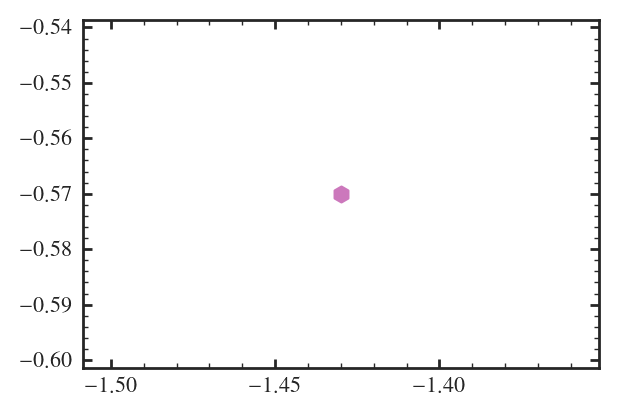

In [80]:
plot_high_z()

# DLA
- As compiled in Cook et al. 2017)

In [81]:
cooke17 = pd.read_csv(DATA_DIR + "cooke17.tsv")

cooke17["C_O"] = cooke17.c_o
cooke17["C_O_err"] = cooke17.c_o_err
cooke17["O_H"] = cooke17.o_h
cooke17["O_H_err"] = cooke17.o_h_err


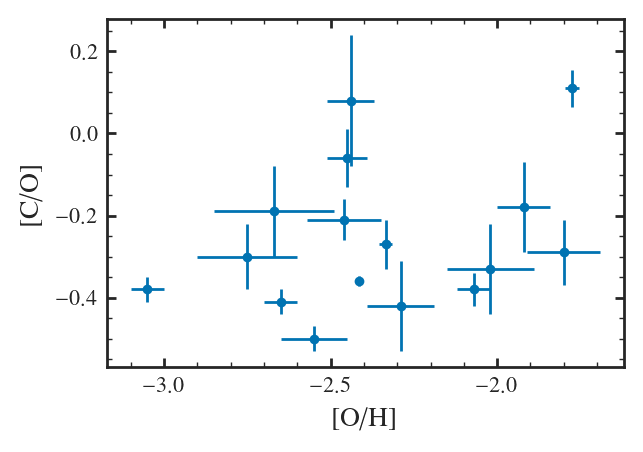

In [82]:
plot_abund_errs(cooke17)

1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014); 4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al. (2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al. (2012); 11: Dessauges-Zavadsky et al. (2003).

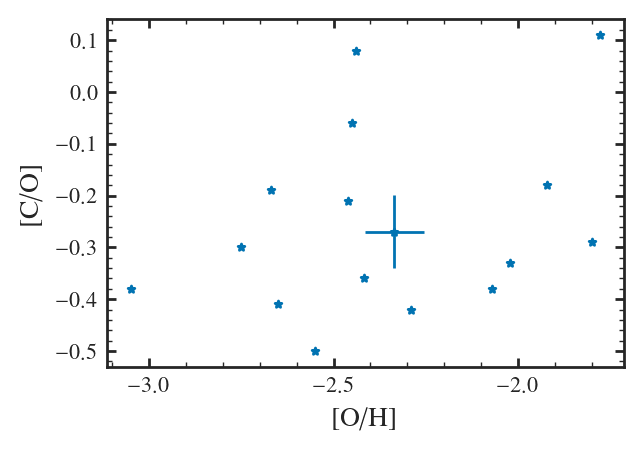

In [83]:
DLA = cooke17
DLA_err = calc_errs(DLA)
plot_sample_err(DLA, DLA_err)

In [84]:
import yaml

In [85]:
with open(DATA_DIR + "high_redshift.yaml", "r") as f:
    df = yaml.safe_load(f)

In [86]:
"log_c_o" in df["iani+2023"].keys()

True

In [87]:
def contains_min_cols(d):
    for col in cols:
        if col not in d.keys():
            print("missing", col)
            return False
    return True

In [88]:
contains_min_cols(df["iani+2023"])

NameError: name 'cols' is not defined

In [89]:
pd.Series(df["iani+2023"])[cols]

NameError: name 'cols' is not defined

In [90]:
df

{'jones+2023': 'jwst result',
 'iani+2023': {'link': 'https://ui.adsabs.harvard.edu/abs/2023MNRAS.518.5018I/abstract',
  'galaxy': 'abell2895b',
  'redshift': 3.72096,
  'redshift_err': 0.00012,
  'eps_o': 7.36,
  'eps_o_err': 0.02,
  'log_c_o': -0.99,
  'log_c_o_err': 0.23,
  'o_lines': '16660.809,1666.150,4960.295,5008.240,4364.436',
  'c_lines': '1906.680,1908.734',
  'Te': '2.2e4,0.2e4',
  'notes': 'oxygen determined by He2-O3C3 diagram (Byler et al. 2020)'},
 'rigby+2021': {'link': 'https://ui.adsabs.harvard.edu/abs/2021ApJ...908..154R/abstract',
  'galaxy': 'J1723+3411',
  'redshift': 1.3293,
  'redshift_err': 0.0002,
  'eps_o': 8.62,
  'eps_o_err': 0.03,
  'log_c_o': 'none'},
 'mathee+2021': {'method': 'CEL stack',
  'link': 'https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.1382M/abstract',
  'galaxy': 'none',
  'redshift': None,
  'eps_o': 8.21,
  'eps_o_err': 0.03,
  'eps_o_err_sys': 0.14,
  'log_c_o': -0.8,
  'log_c_o_err': 0.2},
 'mainali+2020': {'link': 'https://ui.adsabs.ha

In [91]:
def yaml_to_df(y):
    if type(y["galaxy"]) is str:
        series = pd.DataFrame([pd.Series(y)[cols]])
    else:
        ser = {}
        for col in cols:
            ser[col] = y[col]
        print(ser)
        series = pd.DataFrame(ser)
        
    return series

In [92]:
yaml_to_df(df["christensen+2014"])

NameError: name 'cols' is not defined

In [93]:
cols = ["log_c_o", "galaxy", "redshift", "eps_o", "log_c_o_err", "eps_o_err"]

high_z = pd.DataFrame()


for study, attrs in df.items():
    
    if type(attrs) is dict and contains_min_cols(attrs):
        series = yaml_to_df(attrs)
        high_z = pd.concat([high_z, series], ignore_index=True, axis=0)
    else:
        print("warning, incomplete data for", study)

warning, incomplete data for jones+2023
missing log_c_o_err
warning, incomplete data for rigby+2021
missing eps_o_err
warning, incomplete data for berg+2018
missing log_c_o
warning, incomplete data for rigby+2018
warning, incomplete data for perez-montero&amorin2017
missing log_c_o
warning, incomplete data for amorin+2017
missing log_c_o
warning, incomplete data for vanzella+2016
missing log_c_o
warning, incomplete data for bayliss+2014
{'log_c_o': [-1.03, -0.8], 'galaxy': ['A31.1', 'M2031'], 'redshift': [1.8339, 3.5061], 'eps_o': [7.69, 7.76], 'log_c_o_err': [0.08, 0.09], 'eps_o_err': [0.13, 0.03]}
warning, incomplete data for conroy+2014
missing log_c_o
warning, incomplete data for james+2014
missing log_c_o
warning, incomplete data for stark+2014
warning, incomplete data for leitherer2011
warning, incomplete data for leitherer+2011
missing log_c_o
warning, incomplete data for fosbury+2003
warning, incomplete data for fosbury+2003b
missing log_c_o
warning, incomplete data for pettini

/tmp/slurmtmp.29385702/ipykernel_237958/3327155610.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_z = pd.concat([high_z, series], ignore_index=True, axis=0)


In [94]:
high_z

,log_c_o,galaxy,redshift,eps_o,log_c_o_err,eps_o_err
0,-0.99,abell2895b,3.72096,7.36,0.23,0.02
1,-0.80,none,NaN,8.21,0.20,0.03
2,-0.68,RXCJ0232−588,1.64480,7.60,0.19,0.24
3,-0.60,stack,2.40000,8.38,0.09,0.10
4,-1.03,A31.1,1.83390,7.69,0.08,0.13
5,-0.80,M2031,3.50610,7.76,0.09,0.03
6,-0.62,"Q2343-BX418,",2.30480,7.80,0.10,0.10


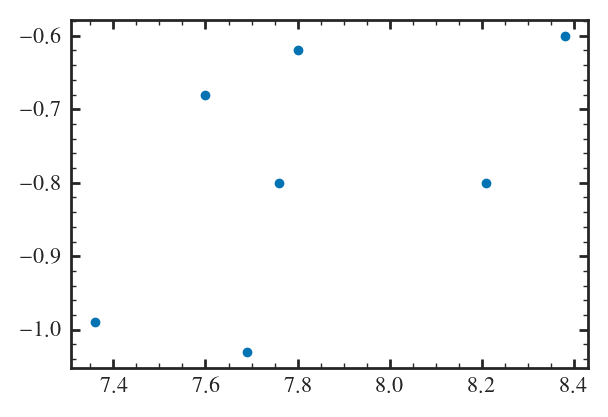

In [95]:
plt.scatter(high_z.eps_o, high_z.log_c_o)

In [96]:
high_z["O_H"] = gcem.eps_to_brak(high_z.eps_o, "o")
high_z["C_O"] = gcem.log_to_brak(high_z.log_c_o, "c", "o")
high_z["O_H_err"] = high_z.eps_o_err
high_z["C_O_err"] = high_z.log_c_o_err

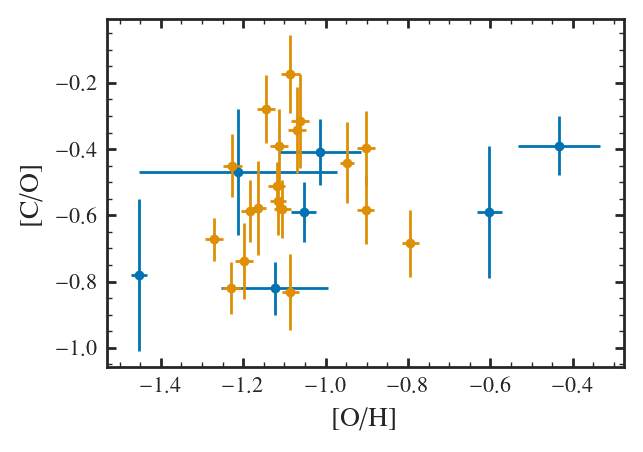

In [97]:
plot_abund_errs(high_z)
plot_abund_errs(berg19)

In [98]:
high_z.log_c_o[2]

-0.68

# Fiducial model

In [80]:
subgiants_ha = subgiants[subgiants.high_alpha]

fiducial = ViceModel.from_file("../models/C11_f0.2/model.json")

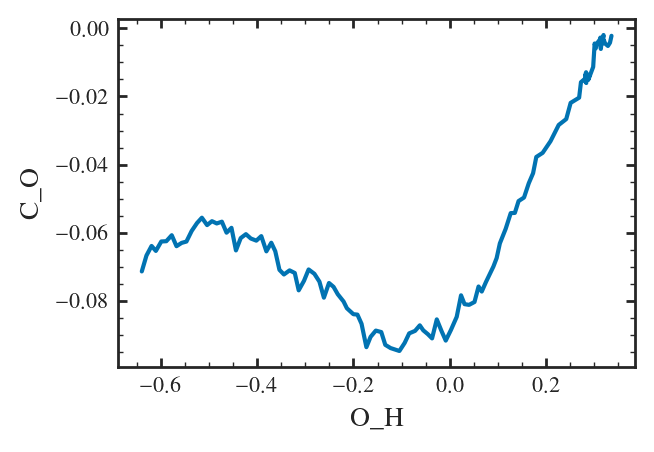

In [81]:
def plot_fiducial():
    surp.plots.plot_annulus_at_t(fiducial, "O_H", "C_O", label="Model (present day)", zorder=9, lw=1.5, color=arya.style.COLORS[0])

plot_fiducial()

Parameters from james et al. dwarf paper:

- $\tau_{\rm in} = 1.01 \pm 0.13\,$Gyr
- $\eta = 8.8 \pm 0.9$
- $\tau_{\star} = 16.1 \pm 1.3\,$Gyr
- $\tau_{\rm end} = 5.4\pm0.3\,$Gyr
- $y_{\rm Fe}^{\rm cc} = 7.8\pm0.4 \times 10^{-4}$
- $y_{\rm Fe}^{\rm Ia} = 1.2\pm0.1\times 10^{-3}$

As we assume different O yields, we adjust $\eta$ accordingly. Our total O yields are 0.712e-3, so
$$
\frac{\eta}{
\eta_{\rm J+22}
} = 
\frac{y_O}{y_{\rm O, J+22}} = \frac{0.712}{1}
$$
in agrement with the difference in alpha-abundance assumptions. 
$$
\eta = 6.2 \pm 0.7
$$

# Singlezone models

## TODO: pull these somehow from the singlezone notebook

In [82]:
yp = surp.YieldParams.from_file("../models/C11_f0.2/yield_params.json")
surp.set_yields(yp)

sz_fiducial = run_singlezone()[1]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0                              
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

change dwarf parameters to
match Wukong from James’ dwarf paper. 𝜂 = 47.99 ± 5, 𝑡end = 3.36 ± 0.5,
𝜏★ = 44.97 ± 7, 𝜏sfh = 3.08 ± 1

In [83]:
run_singlezone?

Signature:
run_singlezone(
    dt=0.01,
    t_end=13.2,
    tau_sfh=14,
    eta=0.5,
    tau_star=2.5,
    mode='sfr',
    sfh=<surp.simulation.sfh_models.insideout object at 0x2b0070ffa470>,
    RIa='plaw',
    Mg0=1,
    verbose=False,
)
Docstring:
Note that the solar model has tau_sfh=14 with an insideout sfh
Parameters
----------
dt : float
    time step in Gyr
t_end : float
    end time in Gyr
sfh : function
    star formation history function. default is exponential
tau_sfh : float
    star formation history decay timescale in Gyr
eta : float
    mass loading factor
tau_star : float
    star formation efficiency timescale in Gyr
mode : str
    star formation mode, see vice documentation
RIa : str
    SNe Ia delay time distribution, "exp" or "plaw", see vice documentation
Mg0 : float
    Total gas mass
verbose : bool
    print vice model info

Returns
-------
out : vice output
    vice output object
history : pandas DataFrame
    history of the singlezone model as a dataframe with

In [84]:
yp = surp.YieldParams.from_file("../models/C11_f0.2_BiLogLin/yield_params.json")
surp.set_yields(yp)

y_scale = 0.6# 0.712

sz_models = [
    run_singlezone()[1],
    run_singlezone(eta=y_scale * 9.56, t_end=10.73, tau_star=26.60, tau_sfh=2.18, sfh=exp_sfh(None), mode="ifr")[1], # GSE
    run_singlezone(eta=y_scale * 48, t_end=3.4, tau_star=45, tau_sfh=3.08, sfh=exp_sfh(None), mode="ifr")[1], # wukong
]

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.30e-03 + 1.62e-03 [M/H] or   1.45 × cristallo11             0                              
                    8.67e-04, else                                                                               

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





/users/PAS2232/aeyobd/VICE/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: o
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/users/PAS2232/aeyobd/VICE/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with thi

In [85]:
MoverH = np.linspace(-5, 0.5)
Z = gcem.MH_to_Z(MoverH)

y_total = gcem.calc_y(Z)
y_agb = gcem.calc_y(Z, kind="agb")
y_cc = gcem.calc_y(Z, kind="cc")
y_ia = gcem.calc_y(Z, kind="ia")

yo = gcem.calc_y(ele="o")

In [86]:
def plot_sz(zorder=10):
    #singlezone
    for i in range(len(sz_models)):
        out = sz_models[i]
        if i == 0:
            label="singlezone"
        else:
            label=""
        plt.plot(out.O_H, out.C_O, label=label, color="k", 
                 lw=1, zorder=zorder, ls=[":", "--", "-."][i])

    plt.plot(sz_fiducial.O_H, sz_fiducial.C_O, label=label, color="k", 
             lw=1, zorder=zorder)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [87]:
sz_models[1]

,time,mgas,mstar,sfr,ifr,ofr,eta_0,r_eff,z_in(c),z_in(n),...,O_H,C_MG,N_MG,O_MG,MG_H,C_FE,N_FE,O_FE,MG_FE,FE_H
0,0.00,1.0,0.000000e+00,3.759398e-11,1.000000,2.156391e-10,5.736,0.095771,0.0,0.0,...,-inf,NaN,NaN,NaN,-inf,NaN,NaN,NaN,NaN,-inf
1,0.01,10000000.0,3.399356e-04,3.759399e-04,0.995423,2.156391e-03,5.736,0.095771,0.0,0.0,...,-10.436896,-0.579706,-0.305588,0.00046,-10.437357,-0.130321,0.143796,0.449845,0.449385,-10.886741
2,0.02,19929270.0,3.399357e+03,7.492207e-04,0.990868,4.297530e-03,5.736,0.120187,0.0,0.0,...,-3.736372,-0.579706,-0.305589,0.00046,-3.736832,-0.130321,0.143796,0.449845,0.449385,-4.186217
3,0.03,29788380.0,9.991095e+03,1.119864e-03,0.986333,6.423540e-03,5.736,0.136515,0.0,0.0,...,-3.435196,-0.579706,-0.305588,0.00046,-3.435657,-0.130321,0.143796,0.449845,0.449384,-3.885041
4,0.04,39577800.0,1.966095e+04,1.487887e-03,0.981819,8.534522e-03,5.736,0.148749,0.0,0.0,...,-3.258956,-0.579706,-0.305589,0.00046,-3.259417,-0.130321,0.143796,0.449845,0.449385,-3.708801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,10.69,326097600.0,1.730708e+08,1.225931e-02,0.007419,7.031938e-02,5.736,0.533510,0.0,0.0,...,-0.578889,-0.164512,-0.255476,0.00046,-0.579349,-0.131138,-0.222102,0.033834,0.033374,-0.612723
1070,10.70,325411400.0,1.731280e+08,1.223351e-02,0.007385,7.017141e-02,5.736,0.533757,0.0,0.0,...,-0.578400,-0.164398,-0.255412,0.00046,-0.578860,-0.131196,-0.222210,0.033662,0.033202,-0.612062
1071,10.71,324726500.0,1.731850e+08,1.220776e-02,0.007352,7.002372e-02,5.736,0.534005,0.0,0.0,...,-0.577911,-0.164284,-0.255349,0.00046,-0.578371,-0.131254,-0.222319,0.033490,0.033030,-0.611401
1072,10.72,324042900.0,1.732419e+08,1.218206e-02,0.007318,6.987631e-02,5.736,0.534252,0.0,0.0,...,-0.577422,-0.164171,-0.255285,0.00046,-0.577883,-0.131313,-0.222427,0.033318,0.032858,-0.610740


Text(0, 0.5, 'sfr')

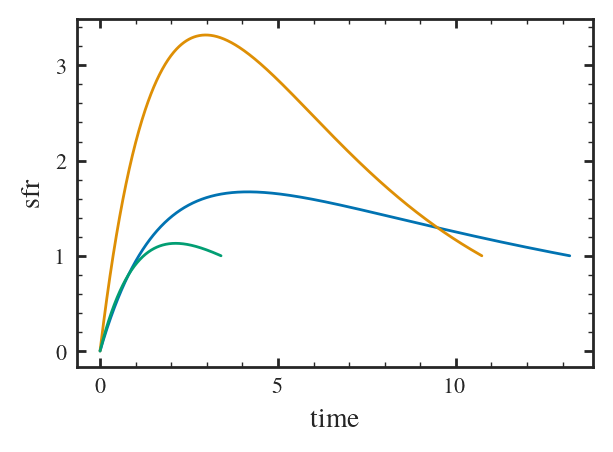

In [88]:
for model in sz_models:
    plt.plot(model.time, model.sfr / model.sfr.iloc[-1])
plt.xlabel("time")
plt.ylabel("sfr")

Text(0, 0.5, 'ifr')

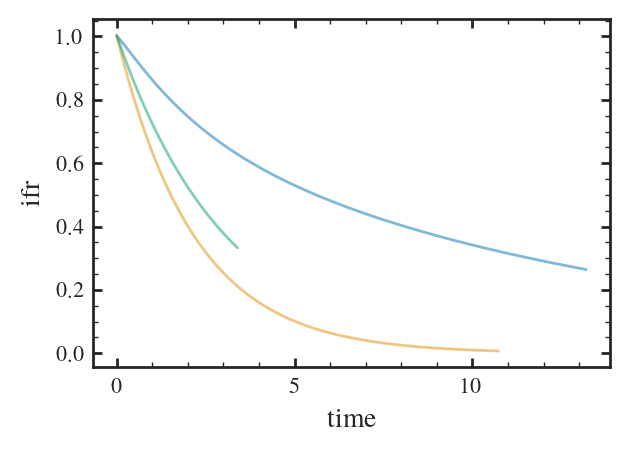

In [89]:
for model in sz_models:
    plt.plot(model.time, model.ifr / model.ifr.iloc[1], alpha=0.5)
plt.xlabel("time")
plt.ylabel("ifr")

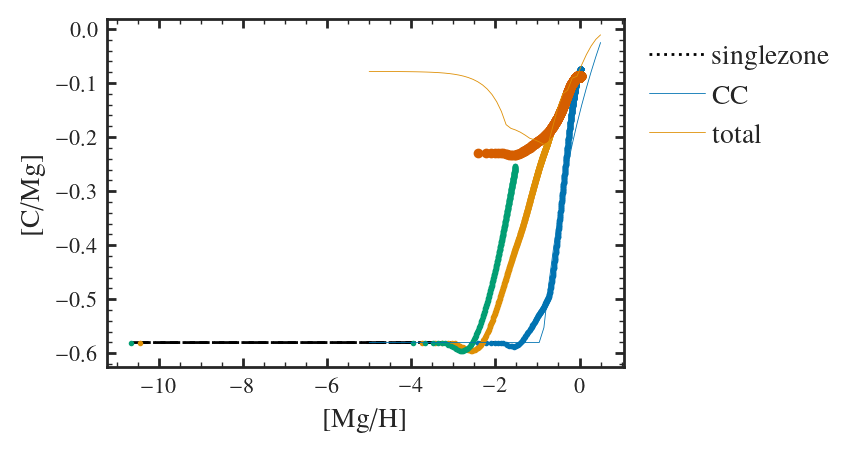

In [90]:
plot_sz(zorder=0)


for h in sz_models:
    plt.scatter(h.O_H, h.C_O, s=1)

plt.scatter(sz_fiducial.O_H, sz_fiducial.C_O)
plt.plot(MoverH, gcem.abund_to_brak(y_cc/yo, "c", "o"), lw=0.3, label="CC")
plt.plot(MoverH, gcem.abund_to_brak(y_total/yo, "c", "o"), lw=0.3, label="total")


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

arya.Legend(-1)

# La Finale

In [91]:
def lower_legend_label(fig):
    plt.ylabel(r"[C/O]")

    lab = plt.xlabel(r"[O/H]")
    
    leg = fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4, markerscale=2)
    box1 = leg.get_tightbbox()
    box2 = lab.get_tightbbox() 

    t1 = box1.transformed(fig.transFigure.inverted())
    t2 = box2.transformed(fig.transFigure.inverted())
    ym = (t2.y0 + t1.y1)/2


    fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))


NameError: name 'lower_legend_label' is not defined

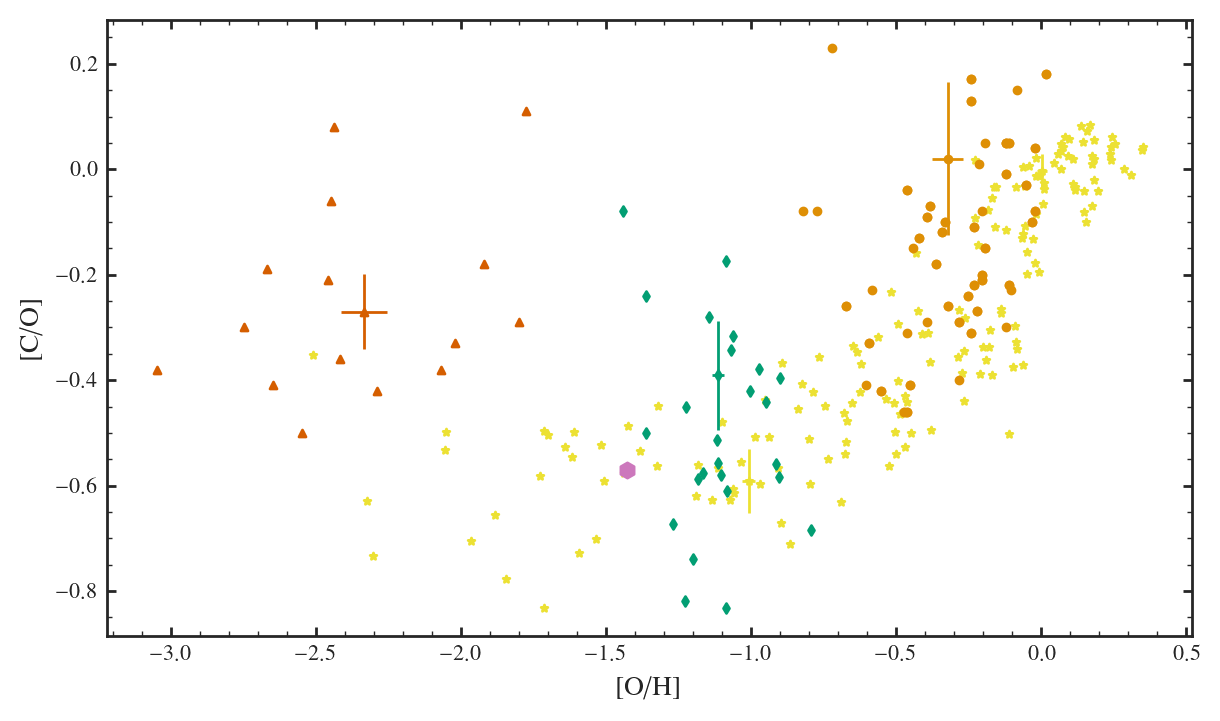

In [99]:
fig = plt.figure(figsize=(7, 4))

plot_sample_err(all_stars, all_star_err, marker="*", color=COLORS[8], label="MW stars")
plot_sample_err(RLs, RL_err, marker="o", color=COLORS[1], label="HII Regions")
plot_sample_err(dwarfs, dwarf_err, marker="d", color=COLORS[2], label="dwarf galaxies")

plot_high_z()

plot_sample_err(DLA, DLA_err, marker="^", color=COLORS[3], label="damped Lyman$\\alpha$ systems")


lower_legend_label(fig)
plt.xlim(-3.25)

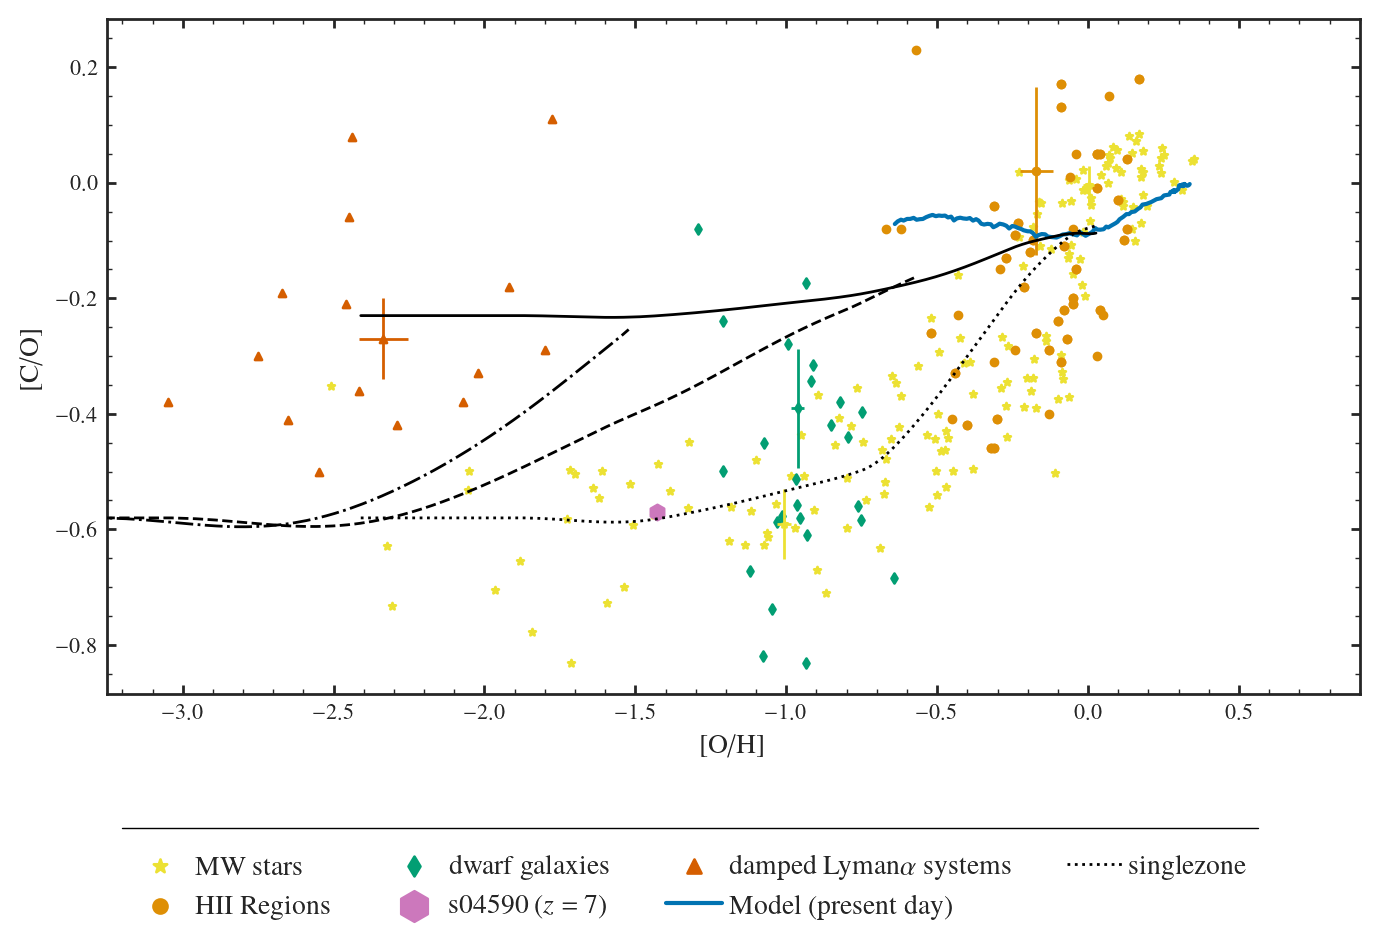

In [92]:
fig = plt.figure(figsize=(7, 4))

plot_sample_err(all_stars, all_star_err, marker="*", color=COLORS[8], label="MW stars")
plot_sample_err(RLs, RL_err, marker="o", color=COLORS[1], label="HII Regions")
plot_sample_err(dwarfs, dwarf_err, marker="d", color=COLORS[2], label="dwarf galaxies")

plot_high_z()

plot_sample_err(DLA, DLA_err, marker="^", color=COLORS[3], label="damped Lyman$\\alpha$ systems")

plot_fiducial()
plot_sz()

lower_legend_label(fig)
plt.xlim(-3.25)
plt.tight_layout()


plt.savefig("figures/summary.pdf")